# 確率ロボティクス2017第7回

上田隆一

2017年10月18日@千葉工業大学

## 1. 今日やること

* 有限マルコフ決定過程

## 2. 有限マルコフ決定過程

* finite Markov decision processes (finite MDPs, 有限MDP)
  * ロボットの行動を考えるときによく使う
    * 行動をするに当たって何が「最適」なのか？
    * 最適にするにはロボットがどうすべきか？
  * 昔ながらの（今も使われる）経路計画の定式化も有限MDPの部分問題
  
## 3. 有限MDPの考え方

* ロボット（環境）の状態は制御出力により遷移
  * これまでの話と同じ
  * 雑音が伴うのも同じ
* 状態をエージェントは観察できる
  * これまでとは違う
* 「こういう状態になったら終わり」という状態が存在
  * 「終端状態」 
  * 例
    * 移動ロボットが目的地に入った状態
    * ロボットが川に落ちた
* 状態遷移にはコストやペナルティーが伴う
  * コスト: 時間、電力消費、燃料消費等
  * ペナルティー: ルール違反、危険な行為に対して

### 例題

次のような簡単な問題を考えてみましょう。

3x3の碁盤の世界を準備します。ロボットはマス目のどこかに存在し、1歩で上下左右に1マス移動できます。ただし、10%の確率で移動に失敗し、元のマス目に戻ります。右上をゴールにして、あるマス目をスタート地点とするとき、何歩でゴールに達するかを、全マス目に対して計算しましょう。ただし、この世界は壁に囲まれていて、壁を超えて移動しようとすると元のマスに戻されます。

次のような変数を準備します。

* goal: ゴールの座標。ゴールは2つ以上でも良いが、この問題では1個だけ
* actions: ロボットが選択できる行動のリスト
* values: 今のところ謎の数字。各マスに対して適当な値を入れておき、ゴールだけ0にしておく。

In [1]:
%matplotlib inline
import numpy as np

size = 3                                                       # 1辺が3マス
values = [[1,1,1],[1,1,1],[1,1,0]]           # 3x3のマス目の世界を作る。数字は今のところ謎の数字としておきます
goal = (2,2)                                               # ゴールを1個だけ座標(2,2)に置く
actions = ["up","down","left","right"]  # ロボットが選択できる行動のリスト

描画してみましょう

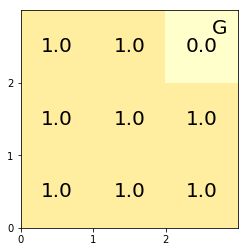

In [2]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

def draw(mark_pos, action):  # mark_pos はあとで使います。
    fig, ax = plt.subplots()
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd,vmin=0,vmax=8)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            plt.text(x+0.5,y+0.5,int(1000*values[x][y])/1000,ha = 'center', va = 'center', size=20)
            
    plt.text(goal[0]+0.75,goal[1]+0.75,"G",ha = 'center', va = 'center', size=20)
    
    if mark_pos != None:   # ここはまだ実装しなくてもよい
        plt.text(mark_pos[0]+0.5,mark_pos[1]+0.25,action,ha = 'center', va = 'center', size=20)
            
    plt.show()
    fig.clear()
    
draw(None,None)

  
## 4. 有限MDPの定式化

### 4.1 状態

* 離散状態の集合を考える
  * $\mathcal{S}= \{s^{(i)} | i=1,2,\dots,N \}$
* 状態が連続の場合は離散化
  * $\mathcal{X}$を区切る 

### 4.2 終端状態

* $s_\text{f} \in \mathcal{S}_\text{f} \subset \mathcal{S}$
* この状態に到達するとそれ以上時間が進まない
* タスクの終わり 

### 4.3 制御出力（行動）

* 有限個の行動の集合から選択
  * $\mathcal{A} = \{ a^{(j)} | j = 1,2,\dots,M \}$
* 連続系の$\mathcal{U}$から何種類か選んで有限個に
* この資料では$s_i,a_j$と書くときは時刻を表すことにします

### 4.4 状態遷移

* $s' \sim P(s' | s,a)$ 
  * $s,s'$はそれぞれ遷移前、遷移後の状態を示す
* $P(s' | s,a)$を$\mathcal{P}^a_{ss'}$と表記しましょう
  * $s \in \mathcal{S} - \mathcal{S}_\text{f}$から$a \in \mathcal{A}$を選択した時、$s' \in \mathcal{S}$に遷移する確率
  
### 4.5 状態遷移の評価

* $R(s,a,s') \in \Re$
  * 評価は常に実数で行われる
* 時刻に依存しないと仮定しましょう
* 評価軸がいくつあっても実数に置き換えて一元化
  * 例: 移動ロボットが水たまりを踏んだら1回につき3分のペナルティー、等
* $R(s,a,s')$を$\mathcal{R}^a_{ss'}$と表記

### 4.6 終端状態の評価

* どの終端状態に行くかも評価の対象
* 終端状態の価値
  * $V(s)\in \Re$ where $\forall s \in \mathcal{S}_\text{f}$
  * この値も$\mathcal{R}^a_{ss'}$と同じ評価軸の上にある
  
### 4.7 行動の評価

* ある状態からスタートして、ある終端状態に入った時の評価の和
* 状態遷移と行動が$s_0,a_1,s_1,a_2,\dots,s_T$だったときの評価:
  * $J(s_{0:T},a_{1:T})$ $ = \mathcal{R}^{a_1}_{s_0s_1} +\mathcal{R}^{a_2}_{s_1s_2} +\mathcal{R}^{a_3}_{s_2s_3} + \dots +\mathcal{R}^{a_T}_{s_{T-1}s_T} + V(s_T)$
$ = \sum_{t=1}^T \mathcal{R}^{a_t}_{s_{t-1}s_t} + V(s_T)  $
* $J(s_{0:T},a_{1:T})$は毎回違う
  * $\mathcal{P}^a_{ss'}$で、事後の状態$s'$がばらつく
  
### 4.8 有限MDPでの最適な行動

* $J(s_{0:T},a_{1:T})$の期待値が最大になる行動決定則
  * 毎回、事後状態がばらつくのにどうやって求めるの？
  * 結構難しい
    * 識別の問題なら判断は1回
    * 行動決定の場合は終端状態に至るまで何度も判断
    

    
## 5. 状態のマルコフ性と最適性の原理

* $\mathcal{P}^a_{ss'}, \mathcal{R}^a_{ss'}$が時不変
  * 違う時刻に同じ状態に来たら、同じ行動をとれば同じ確率分布で次の状態に遷移し、同じように評価される
* これが成り立つと・・・
  * ある試行の状態遷移$s_0,s_1,s_2,\dots,s_N$のうち、どこを初期状態にしても、$J(s_{0:T},a_{1:T})$の期待値を最大にする問題は、同じ問題になる。
  
## 6. 状態の価値

* $J(s_{0:T},a_{1:T})$の期待値の最大値を考えてみる 
  * 先ほどの議論から、$J(s_{0:T},a_{1:T})$の期待値の最大値が存在すると仮定すると、初期状態だろうがなかろうが、ある状態$s$から先の行動決定を考えると、この期待値の最大値が存在するし、それは、その状態$s$の関数となる
  * これをその状態の（エージェントが最適な行動を取った時の）「価値」と言う
* 終端状態の価値$V(s) ( s \in \mathcal{S}_\text{f})$を拡張して、状態空間全体の関数: $V^*: \mathcal{S} \to \Re$とする
  * $V^*$: 最適状態価値関数 

## 7. 価値の性質（ベルマン方程式）

* $V^* (s) = \max_{a\in\mathcal{A}} \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a \left[ V^*(s') + \mathcal{R}_{ss'}^a \right] $
  * もし最適状態価値関数が存在するなら、ある状態$\forall s \in \mathcal{S}-\mathcal{S}_\text{f}$の値$V^*(s)$は、以下の値を最大にする行動$a \in \mathcal{A}$を選んだ時の値になる
    * $s$から遷移した先の値$V^*(s')$と、その状態遷移に対する評価$\mathcal{R}_{ss'}^a$を足した値を考える。遷移先は確率的にばらつくので、この値について$\mathcal{P}_{ss'}^a$で重み付き平均を求めたもの。

## 8. 価値の計算（価値反復）

* ある状態$s$の$V^*(s)$だけ分からない。あとの状態の$V^*$の値は分かるという、都合の良い>状況を考えてみましょう。
  * 価値の計算式はベルマン方程式そのものとなる
    * $V^* (s) =\max_{a\in\mathcal{A}} \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a \left[ V^*(s') + \mathcal{R}_{ss'}^a \right] $
* 価値反復アルゴリズム
  * 終端状態の価値以外を適当に初期化して、上の計算を$\forall s \in \mathcal{S} - \mathcal{S}_\text{f}$に対して何度も計算していく
  * 終端状態に近い状態から$V^* (s)$の値が収束していく 

## 9. 最適方策

* 最適状態価値関数が分かっていると、ベルマン方程式を成立させるための行動が求まる
  * 最適な行動: $\text{argmax}_a \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a \left[ V^*(s') + \mathcal{R}_{ss'}^a \right] $
* 「最適方策」
  * $\pi^*: \mathcal{S}-\mathcal{S}_\text{f} \to \mathcal{A}$
    * 最適方策は状態と行動を対にしたリストとなる
    * 時刻は全く関係ない
    * $\pi^*$を知っているロボットは、置き直されたりタスクを妨害されたりしても、その後に自身の状態を知覚できれば、最適な行動をとることが可能

## 10. 価値反復の実装

### 行動価値の計算式

歩行の即時コスト1＋遷移先の価値を返します。

In [3]:
# 指定した座標のコストを返す補助の関数
def postvalue(pos,action):
    p = [pos[0],pos[1]]
    if   action == "up":    p[1] += 1
    elif action == "down":  p[1] -= 1
    elif action == "left":  p[0] -= 1
    elif action == "right": p[0] += 1
    
    for i in [0,1]:  # 壁にぶつかったらそのまま
        if p[i] < 0:     p[i] = 0
        if p[i] >= size: p[i] = size - 1
            
    return values[p[0]][p[1]]

def action_value(pos, action, goal):
    if pos == goal: return values[pos[0]][pos[1]]    # ゴールの価値は不変
    
    cur_v = values[pos[0]][pos[1]]
    post_v = postvalue(pos,action)
    
    return 1.0 + 0.9*post_v + 0.1*cur_v    #1歩にコスト1がかかる。90%で別の状態へ、10%でそのまま

確認

* (2,1)で上向きに行動するときの価値
* (0,0)で下向きに行動するときの価値

In [4]:
print(action_value((2,1),"up",goal))
print(action_value((0,0),"down",goal))

1.1
2.0


一番良い行動価値で価値関数（配列values）を更新し続けて値が変わらなくなったら出力

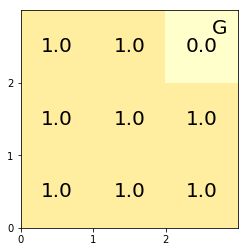

sweep 1


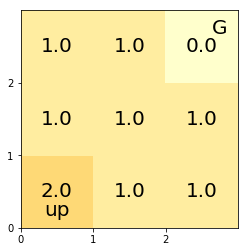

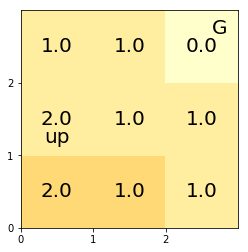

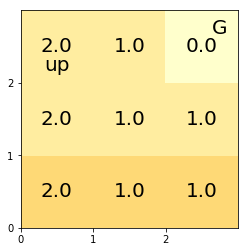

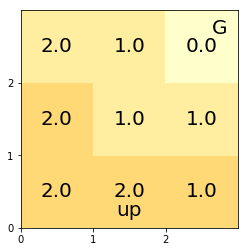

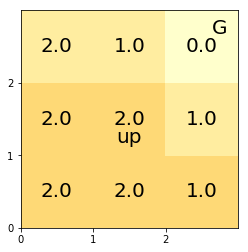

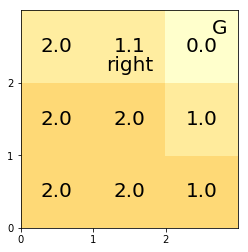

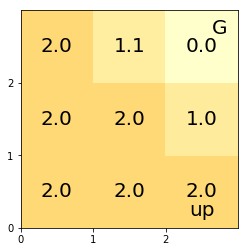

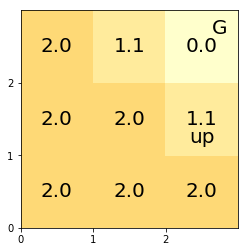

sweep 2


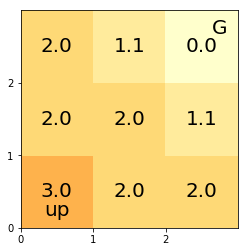

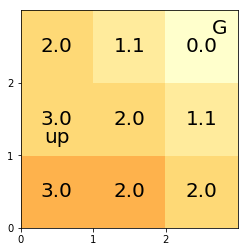

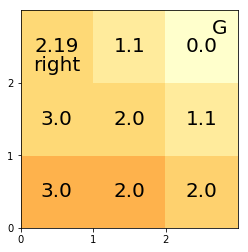

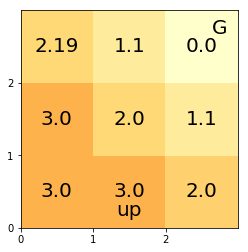

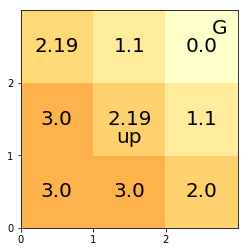

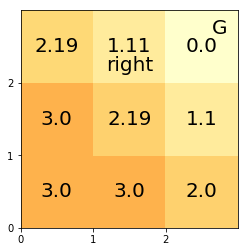

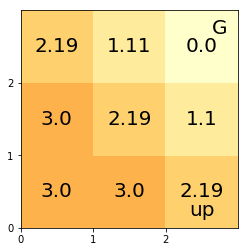

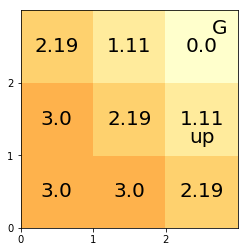

sweep 3


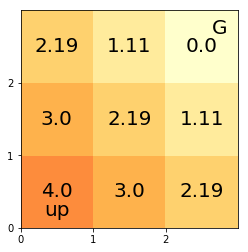

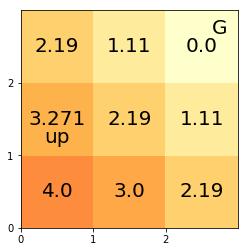

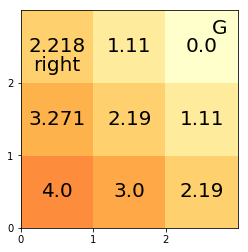

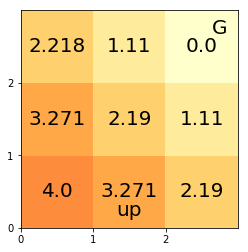

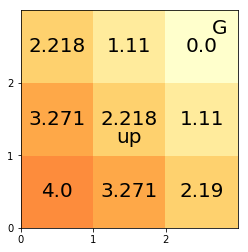

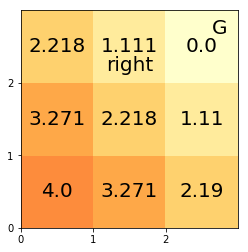

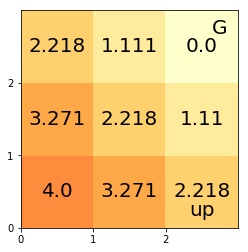

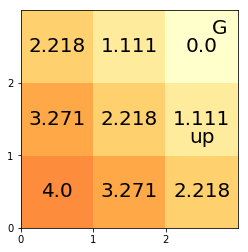

sweep 4


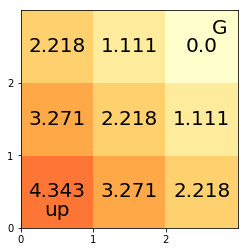

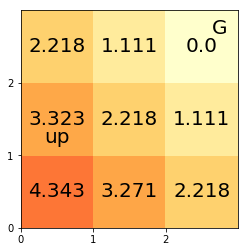

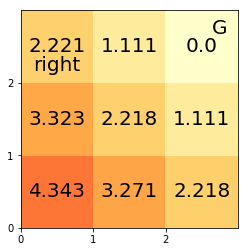

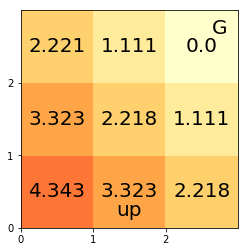

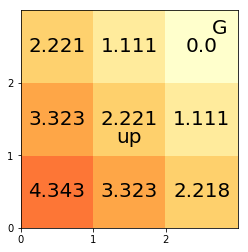

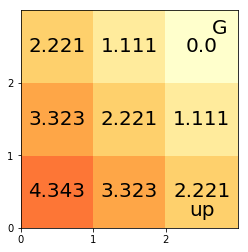

sweep 5


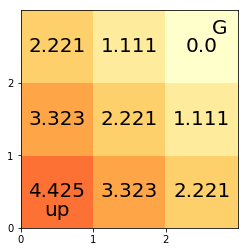

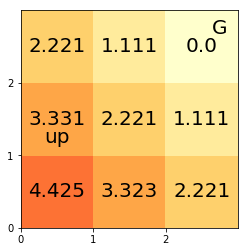

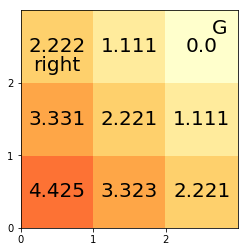

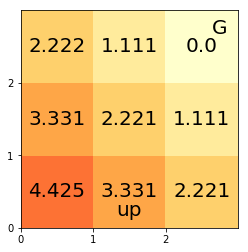

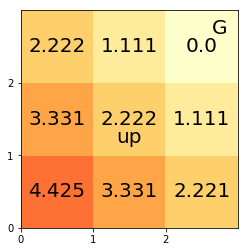

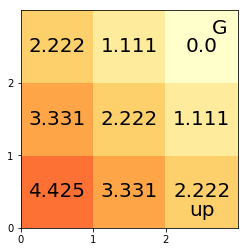

sweep 6


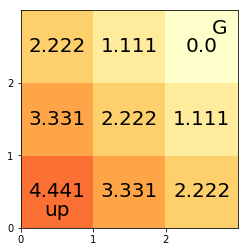

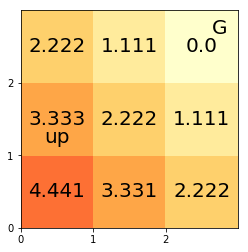

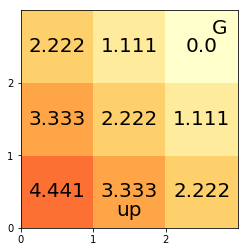

sweep 7


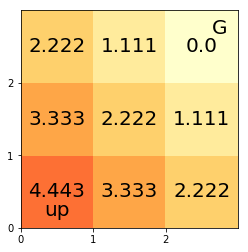

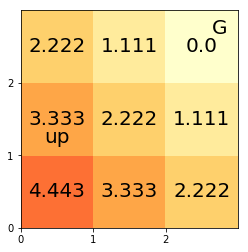

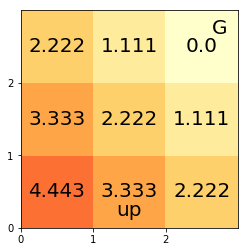

sweep 8


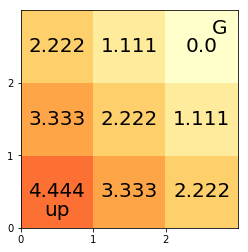

sweep 9


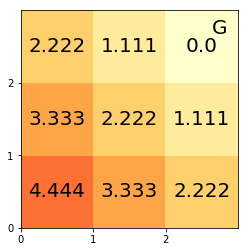

In [5]:
import math

def sweep():                # 全状態に価値反復の式を適用することは「スイープ」と呼ばれます
    changed = False
    
    for x in range(size):
        for y in range(size):
            best_value = 100
            best_action = None
            for a in actions:
                c = action_value((x,y), a, goal)
                if c < best_value:
                    best_value = c
                    best_action = a

            if math.fabs(values[x][y] - best_value) > 0.0001:
                values[x][y] = best_value
                draw((x,y),best_action)
                changed = True

    return changed

draw(None,None)
changed = True
n = 1
while changed:
    print("sweep",n)
    changed = sweep()
    n = n + 1
    
draw(None,None)